# Calculation of Mortality Rate – Demographic Flow Method  
*(Argentina example — reverse-engineering deaths from population balances)*

## 1. Core idea
Population changes from births, migration and deaths:

$$
P_{t+1} = P_t + \text{Births}_t + \text{Immigration}_t - \text{Emigration}_t - \text{Deaths}_t
$$

## 2. Solve for deaths
Rearrange to estimate deaths:

$$
\text{Deaths}_t = P_t + \text{Births}_t + \text{Immigration}_t - \text{Emigration}_t - P_{t+1}
$$

(Plug observed P, births and migration for the year t.)

## 3. Why it works for Argentina (brief)
- INDEC publishes annual population and births.  
- Migration estimates + population totals let you back-calculate deaths even when death registration is delayed.

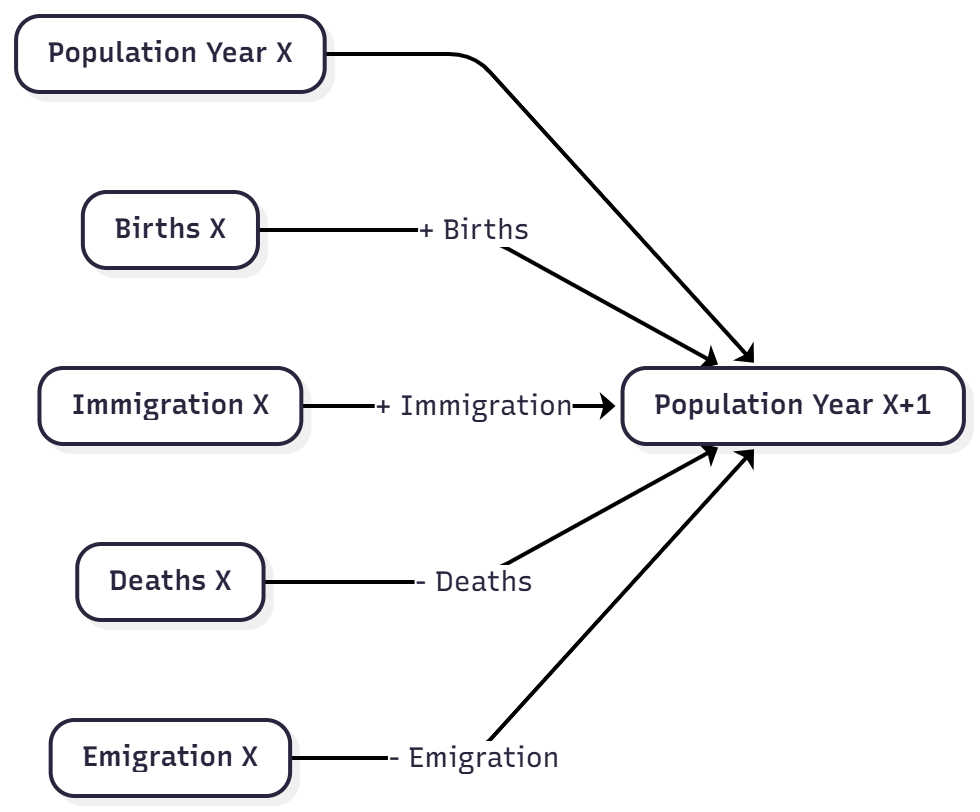


## Data Preparation

To begin the analysis, we first load and preprocess the raw datasets so they fit the structure required for the demographic model.

---

### 1. Births (2005–2023)

- Import the births dataset.
- Filter the years relevant for the study (2019–2023).
- Sort the data by year and reset the index.
- Preview the cleaned dataset using `births.tail()`.

---

### 2. Population (2005–2024)

- Load the official annual population dataset.
- Keep only data from 2019 onward.
- Sort the records in chronological order.
- Reset the index to maintain consistency across datasets.

---

### 3. Migrations (2019–2024)

- Import the migration dataset containing annual entries and exits.
- Clean and normalize the column names to avoid formatting inconsistencies.

---

### 4. Data Unification

To perform the mortality calculation using the demographic flow method, we must consolidate the isolated datasets into a single analytical dataframe. 

We will merge the **Population**, **Births**, and **Migrations** dataframes using the `YEAR` column as the common key.

The final unified dataset will contain the following components for each year (2019–2023):

* **YEAR**: The reference time period.
* **POPULATION**: Total population estimate for the specific year ($P_t$).
* **BIRTHS**: Total live births registered ($B_t$).
* **IMMIGRATION**: Total entries into the country ($I_t$).
* **EMIGRATION**: Total exits from the country ($E_t$).
* **TOTAL_MIGRATION**: The sum of all movement (Entries + Exits), mostly for validation purposes.

Once merged, we will be able to apply the formula:
$$D_t = P_t + B_t + (I_t - E_t) - P_{t+1}$$

### 1. Births (2005–2023)

- Import the births dataset.
- Filter the years relevant for the study (2019–2023).
- Sort the data by year and reset the index.
- Preview the cleaned dataset using `births.tail()`.

In [1]:
import csv
import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
df = pd.read_excel('dataset/nacimientos-2005-2023.xlsx', engine='openpyxl')

In [3]:
# We filter our desired year (2019-2023); we sort by Year; we reset indexes; We rename columns; We drop unnecesary column
births = df.loc[df['AÑO'] > 2018].sort_values(by='AÑO', ascending=True).reset_index(drop=True)
births = births.rename(columns={'AÑO': 'YEAR', 'NACIDOS_VIVOS_REGISTRADOS': 'BIRTHS'}).drop(['AREA'], axis = 1)

In [4]:
births.tail()

,YEAR,BIRTHS
0,2019,625441
1,2020,533299
2,2021,529794
3,2022,495295
4,2023,460902


---

### 2. Population (2005–2024)

- Load the official annual population dataset.
- Keep only data from 2019 onward.
- Sort the records in chronological order.
- Reset the index to maintain consistency across datasets.

In [5]:
df = pd.read_csv('dataset/poblacion-argentina-2005-2024.csv')

In [6]:
population = df.loc[df['Year'] > 2018].sort_values(by='Year', ascending=True).reset_index(drop=True)
population = population.rename(columns={'Year': 'YEAR', 'Total': 'POPULATION'})

---

### 3. Migrations (2019–2024)

- Import the migration dataset containing annual entries and exits.
- Clean and normalize the column names to avoid formatting inconsistencies.

In [7]:
df_2 = pd.read_csv('dataset/migraciones-2019-2024.csv')
df_2.head()

,ANIO,ENTRADAS,SALIDAS,TOTAL_SUMA,TOTAL_RESTA
0,2019,34.413.753,34.522.066,68.935.819,−108313
1,2020,9.705.757,9.541.981,19.247.738,163776
2,2021,3.110.402,3.347.356,6.457.758,−236954
3,2022,24.036.545,23.911.744,47.948.289,124801
4,2023,37.118.359,36.522.139,73.640.498,596022


In [8]:
df_2.columns = df_2.columns.str.strip()
migrations = df_2.rename(columns={
    'ANIO': 'YEAR',
    'ENTRADAS': 'IMMIGRATION',
    'SALIDAS': 'EMIGRATION',
    'TOTAL_RESTA': 'TOTAL_MIGRATION',
    'TOTAL_SUMA': 'TOTAL_SUM'
})

migrations.head()


,YEAR,IMMIGRATION,EMIGRATION,TOTAL_SUM,TOTAL_MIGRATION
0,2019,34.413.753,34.522.066,68.935.819,−108313
1,2020,9.705.757,9.541.981,19.247.738,163776
2,2021,3.110.402,3.347.356,6.457.758,−236954
3,2022,24.036.545,23.911.744,47.948.289,124801
4,2023,37.118.359,36.522.139,73.640.498,596022


---

### 4. Data Unification

We will merge the **Population**, **Births**, and **Migrations** dataframes using the `YEAR` column as the common key.

We will clean the column data types so it matches our goal.

In [9]:
dataframes = [population, migrations, births]
df = reduce(lambda left, right: pd.merge(left, right, on ='YEAR', how = 'inner'), dataframes)
df

,YEAR,POPULATION,IMMIGRATION,EMIGRATION,TOTAL_SUM,TOTAL_MIGRATION,BIRTHS
0,2019,44973465,34.413.753,34.522.066,68.935.819,−108313,625441
1,2020,45191965,9.705.757,9.541.981,19.247.738,163776,533299
2,2021,45312281,3.110.402,3.347.356,6.457.758,−236954,529794
3,2022,45407904,24.036.545,23.911.744,47.948.289,124801,495295
4,2023,45538401,37.118.359,36.522.139,73.640.498,596022,460902


In [10]:
cols_to_fix = ['IMMIGRATION', 'EMIGRATION']

for col in cols_to_fix:
    cleaned = df[col].astype(str).str.replace(".", "", regex=False)
    df[col] = pd.to_numeric(cleaned, errors='coerce').astype(int)

df

,YEAR,POPULATION,IMMIGRATION,EMIGRATION,TOTAL_SUM,TOTAL_MIGRATION,BIRTHS
0,2019,44973465,34413753,34522066,68.935.819,−108313,625441
1,2020,45191965,9705757,9541981,19.247.738,163776,533299
2,2021,45312281,3110402,3347356,6.457.758,−236954,529794
3,2022,45407904,24036545,23911744,47.948.289,124801,495295
4,2023,45538401,37118359,36522139,73.640.498,596022,460902


Now we apply the Mortality Formula
$$D_t = P_t + B_t + (I_t - E_t) - P_{t+1}$$

In [11]:

pop_series = population.set_index('YEAR')['POPULATION']

df['POP_t1'] = df['YEAR'].map(lambda y: pop_series.get(y + 1, np.nan))
df['MORTALITY'] = df['POPULATION'] + df['BIRTHS'] + (df['IMMIGRATION'] - df['EMIGRATION']) - df['POP_t1']

df['MORTALITY'] = df['MORTALITY'].astype('Int64')

df = df[['YEAR', 'POPULATION', 'BIRTHS', 'IMMIGRATION', 'EMIGRATION', 'MORTALITY']]
df

,YEAR,POPULATION,BIRTHS,IMMIGRATION,EMIGRATION,MORTALITY
0,2019,44973465,625441,34413753,34522066,298628
1,2020,45191965,533299,9705757,9541981,576759
2,2021,45312281,529794,3110402,3347356,197217
3,2022,45407904,495295,24036545,23911744,489599
4,2023,45538401,460902,37118359,36522139,899364


### 5. Data Visualization

To better understand the evolution of Argentina’s demographic components, we generate visualizations using `matplotlib` and `seaborn`.

Two types of plots are produced:

#### **5.1 Combined Line Plot**

All demographic variables (population, immigration, emigration, total migration, births) are reshaped into long format and plotted on the same graph.  
The Value axis is normalized to show values in **millions**, improving readability.

#### **5.2 Individual Subplots for Each Variable**

Each variable is also displayed separately in its own subplot.  
All charts share:

- Year on the x-axis  
- Values in millions on the y-axis  
- Line markers  
- Grid lines for clarity  

These visualizations help reveal trends such as population growth, migration fluctuations, and birth variations across the selected years.


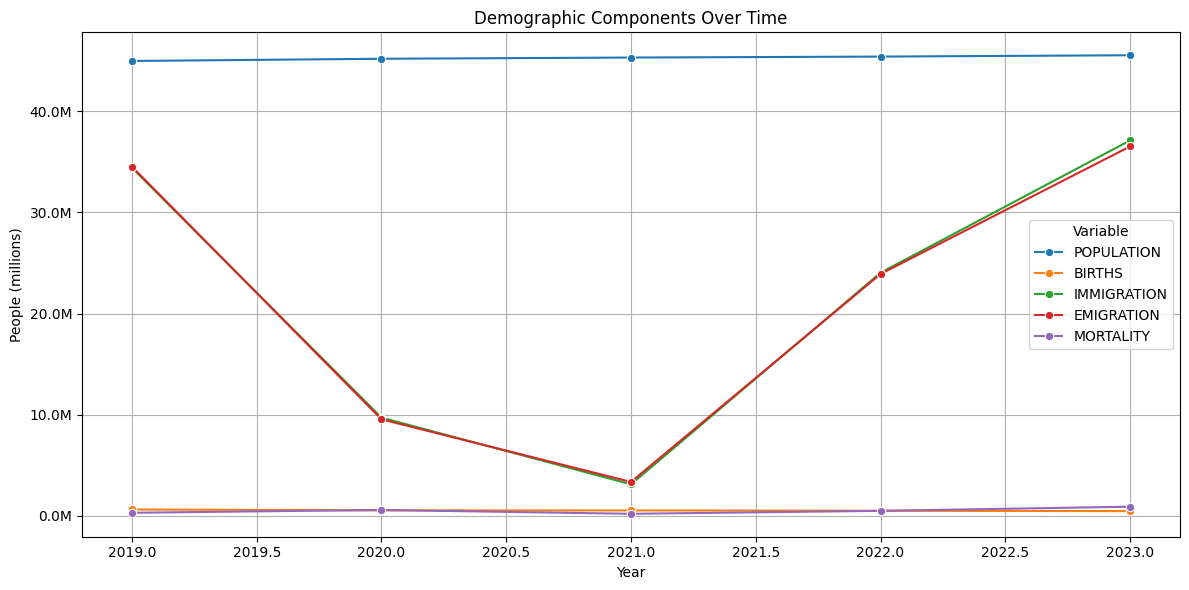

In [12]:
df_long = df.melt(id_vars='YEAR', var_name='Variable', value_name='Value')


def millions(x, pos):
    return f'{x/1_000_000:.1f}M'

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_long, x='YEAR', y='Value', hue='Variable', marker='o')

plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))

plt.title("Demographic Components Over Time")
plt.xlabel("Year")
plt.ylabel("People (millions)")
plt.grid(True)
plt.tight_layout()
plt.show()

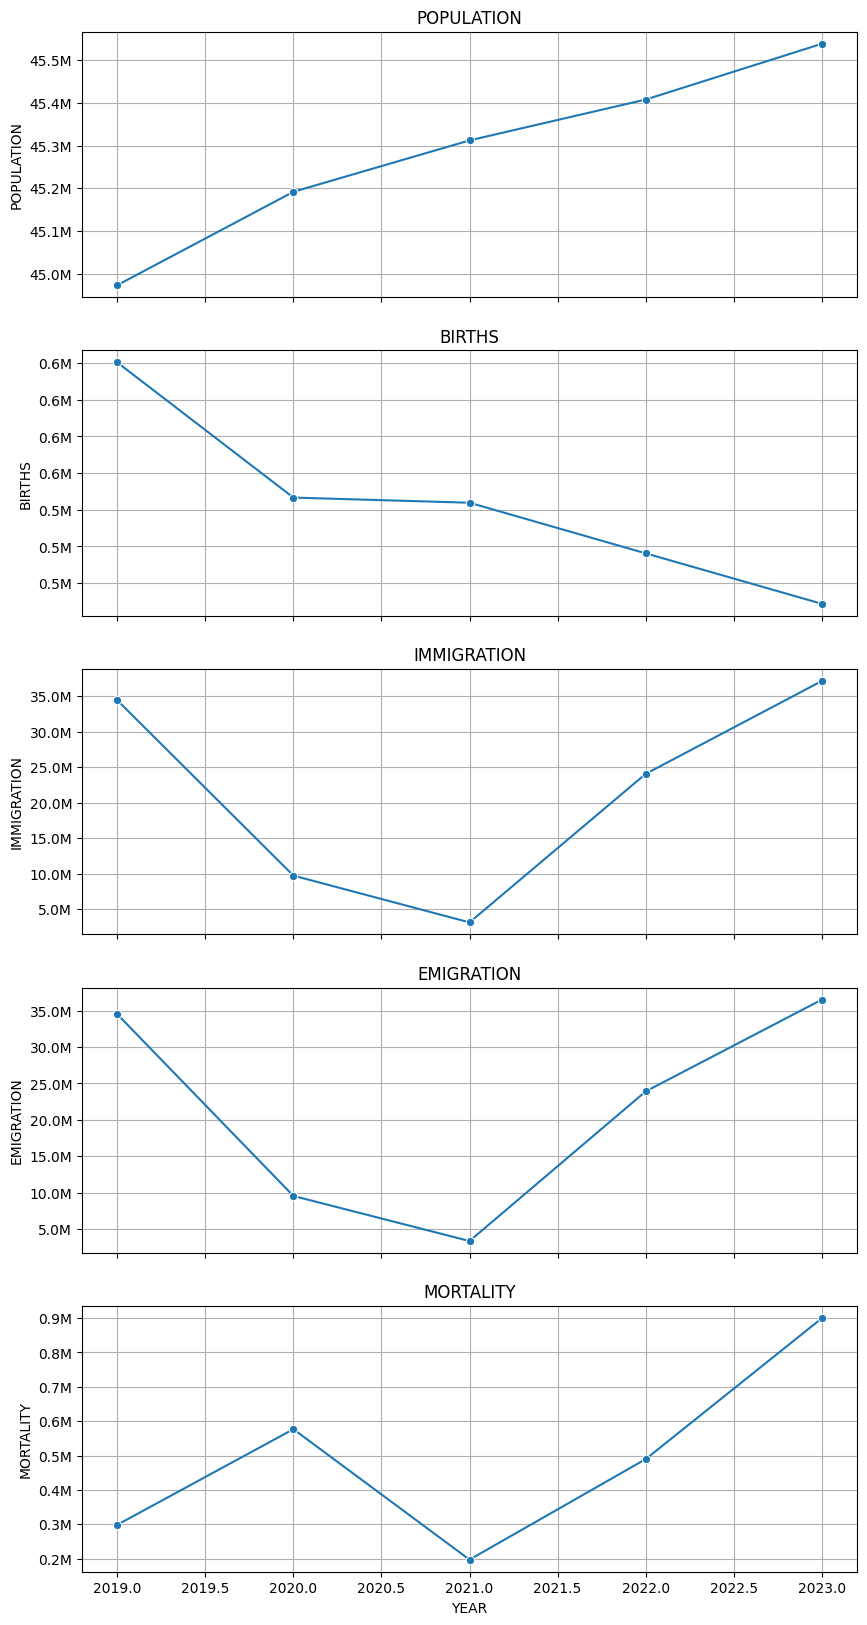

In [13]:
cols = [c for c in df.columns if c != 'YEAR']

# Create subplots
fig, axes = plt.subplots(
    nrows=len(cols), 
    ncols=1, 
    figsize=(10, 4 * len(cols)), 
    sharex=True
)

for ax, col in zip(axes, cols):
    sns.lineplot(data=df, x='YEAR', y=col, marker='o', ax=ax)

    ax.set_title(col)
    ax.yaxis.set_major_formatter(FuncFormatter(millions))
    ax.grid(True)


### 6. Mortality Calculation Comparison

After computing mortality using the Demographic Flow Method, we compare our estimated deaths with official mortality data obtained from external sources.

#### **Purpose of the Comparison**

- Evaluate how closely the demographic flow model matches real-world mortality records  
- Identify discrepancies arising from migration reporting gaps, population estimation uncertainty, or birth registry delays  
- Validate the reliability of the computed deaths over the 2019–2023 period  

#### **Comparison Method**

1. We obtain official mortality numbers from a reliable statistical source (e.g., Argentina's Ministry of Health or INDEC).
2. We align the official mortality dataset by year to match our unified demographic table.
3. We compute and visualize:
   - The difference between official mortality and model-estimated mortality
   - The percentage error for each year
   - Trend consistency between both datasets

#### **Outcome**

This comparison reveals how well the demographic model reconstructs mortality and helps identify years where external factors (registration delays, migration noise, census corrections) may cause divergences.


#### **Comparison Method**

We are going to compare our dataset with the dataset obtained from [Datosmacro Mortality in Argentina ](https://datosmacro.expansion.com/demografia/mortalidad/argentina)

In [14]:
mortality_df = pd.DataFrame({'YEAR': [2019, 2020, 2021, 2022, 2023], 
                             'EXPECTED_MORTALITY': [344952, 381872, 440662, 399453, 349188]})

mortality_df

,YEAR,EXPECTED_MORTALITY
0,2019,344952
1,2020,381872
2,2021,440662
3,2022,399453
4,2023,349188


Let's add it to our Dataset

In [15]:
# Merge expected mortality into df
df = df.merge(mortality_df, on='YEAR', how='left')

# Ensure integer nullable dtype
df['EXPECTED_MORTALITY'] = df['EXPECTED_MORTALITY'].astype('Int64')

df

,YEAR,POPULATION,BIRTHS,IMMIGRATION,EMIGRATION,MORTALITY,EXPECTED_MORTALITY
0,2019,44973465,625441,34413753,34522066,298628,344952
1,2020,45191965,533299,9705757,9541981,576759,381872
2,2021,45312281,529794,3110402,3347356,197217,440662
3,2022,45407904,495295,24036545,23911744,489599,399453
4,2023,45538401,460902,37118359,36522139,899364,349188


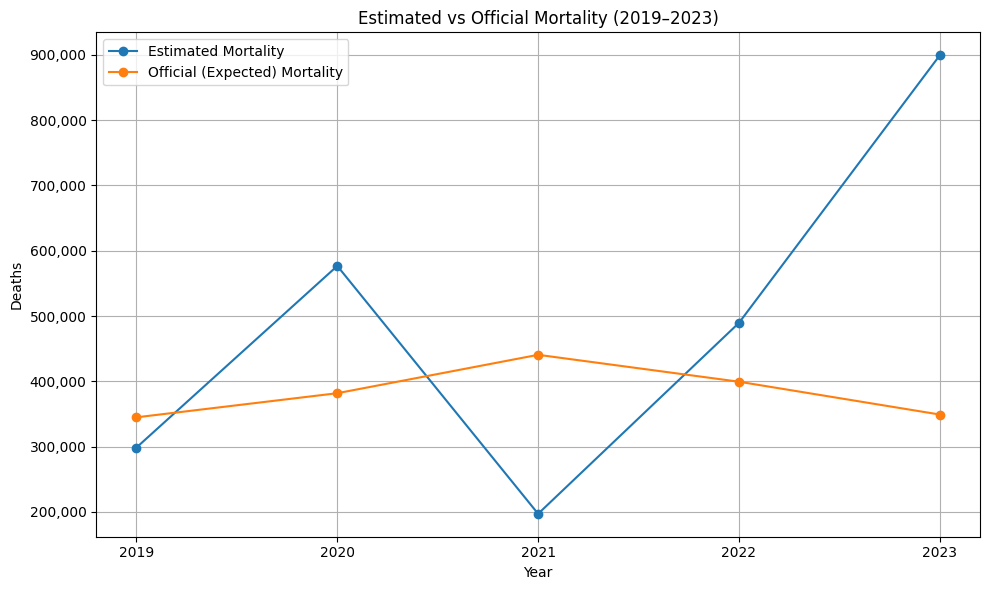

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['YEAR'], df['MORTALITY'].astype(int), marker='o', label='Estimated Mortality')
ax.plot(df['YEAR'], df['EXPECTED_MORTALITY'].astype(int), marker='o', label='Official (Expected) Mortality')

ax.set_title('Estimated vs Official Mortality (2019–2023)')
ax.set_xlabel('Year')
ax.set_ylabel('Deaths')
ax.set_xticks(df['YEAR'])
ax.grid(True)
ax.legend()

# Use comma thousands separator for readability
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))

plt.tight_layout()
plt.show()